In [31]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm as lgb
import seaborn as sns
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [32]:
for p in [np, pd, sklearn, scipy, lgb, sns]:
    print (p.__name__, p.__version__)

numpy 1.14.2
pandas 0.23.4
sklearn 0.19.1
scipy 0.19.1
lightgbm 2.1.1
seaborn 0.8.0


# load the data

In [33]:
import os
import tarfile
from six.moves import urllib
PATH = os.path.join("journey", "data")
def load_data(file):
    csv_path = os.path.join(PATH,file)
    return pd.read_csv(csv_path)

In [34]:
sales = load_data('sales_train.csv')
shops = load_data('shops.csv')
items = load_data('items.csv')
item_cats = load_data('item_categories.csv')
test = load_data('test.csv')

In [35]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [36]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [37]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [38]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [39]:
print("sales----------------------------")
sales.info()
print("shops----------------------------")
shops.info()
print("items----------------------------")
items.info()
print("item_cats----------------------------")
item_cats.info()
print("test----------------------------")
test.info()

sales----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
shops----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB
items----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
item_cats----------------------------
<class 'pandas.core.frame.DataFrame'

# item

In [40]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


* this dataset has a primary key= (item_id)

40    5035
55    2365
37    1780
31    1125
58     790
30     756
72     666
19     628
61     598
23     501
43     471
57     427
56     397
67     394
63     366
76     333
41     332
69     317
38     310
62     295
59     294
64     290
78     278
75     277
28     240
70     228
77     220
45     195
66     178
20     175
49     167
65     163
44     161
47     151
25     140
21     125
24     123
54      90
22      79
2       75
60      52
29      46
11      41
6       40
15      37
73      36
3       34
5       29
68      27
7       24
12      20
16      20
33      18
14      18
4       15
83      15
42      12
9       12
46      12
8        9
82       8
34       8
27       8
74       8
17       7
81       7
39       7
71       6
36       6
32       6
80       6
18       6
13       6
48       5
0        4
35       4
52       3
53       3
26       3
50       2
1        2
51       1
10       1
79       1
Name: item_category_id, dtype: int64


C:\Users\Hamza SBAAI\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



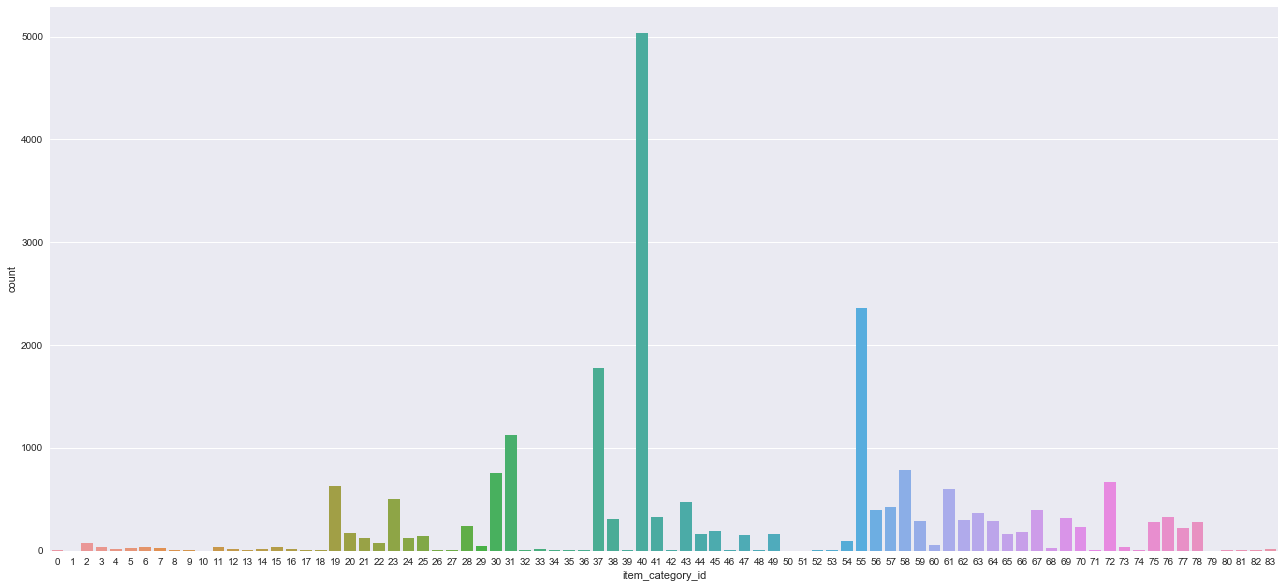

In [41]:
# item_category_id
print(items['item_category_id'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(items['item_category_id'])
plt.show()

# item_cats datasets
 * this dataset is just obout the name of each item_category_id
 * so all we can do with this data is to come up with a new feature 


In [42]:
l=[i.split("-")[0] for i in list(item_cats.item_category_name) ] 

item_cats['cats'] = l
item_cats.head()

,item_category_name,item_category_id,cats
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Программы                             6
Музыка                                6
Кино                                  5
Карты оплаты                          4
Игры PC                               4
Чистые носители (шпиль)               1
Карты оплаты (Кино, Музыка, Игры)     1
Чистые носители (штучные)             1
Игры MAC                              1
Доставка товара                       1
Служебные                             1
Билеты (Цифра)                        1
Игры Android                          1
Служебные                             1
PC                                    1
Элементы питания                      1
Name: cats, dtype: int64


C:\Users\Hamza SBAAI\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



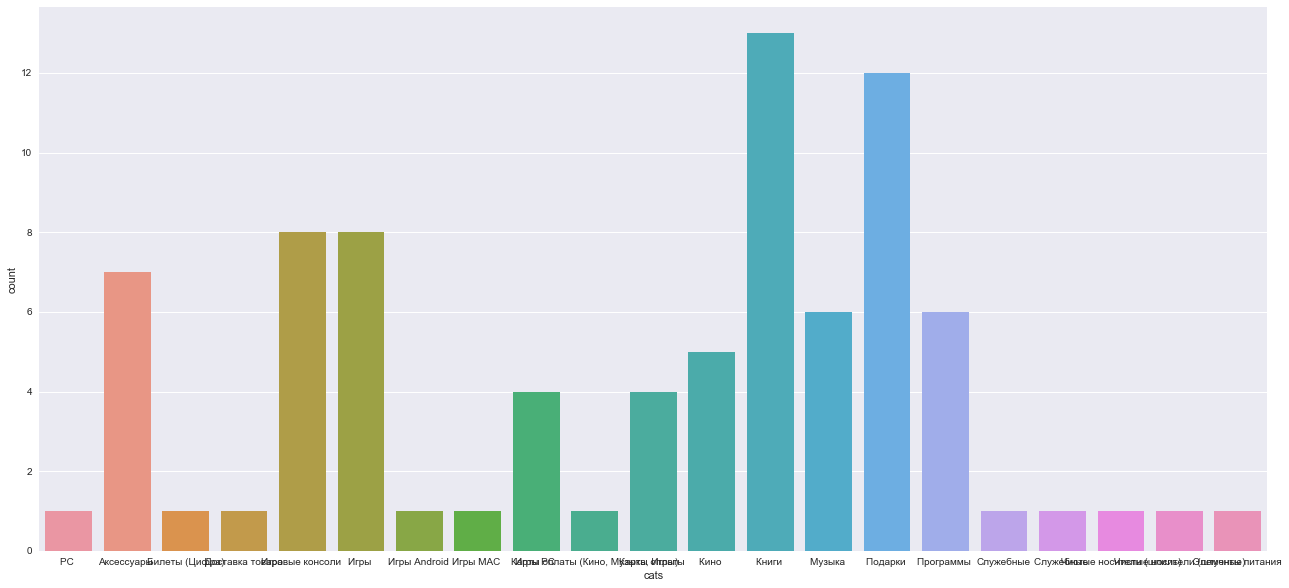

In [43]:
print(item_cats['cats'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(item_cats['cats'])
plt.show()

In [44]:
l=[i.split("-")[0] for i in list(item_cats.item_category_name) ] 
l=[i.split(" ")[0] for i in l ] 

item_cats['cats'] = l
item_cats.head()

,item_category_name,item_category_id,cats
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


### now lets merge those two datasets 


In [45]:
item_to_cat_df = items.merge(item_cats, how="inner", on="item_category_id")[['item_id',"item_category_id",'cats']]
item_to_cat_df.head()

,item_id,item_category_id,cats
0,0,40,Кино
1,2,40,Кино
2,3,40,Кино
3,4,40,Кино
4,5,40,Кино


Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Программы      6
Музыка         6
Карты          5
Кино           5
Чистые         2
Служебные      2
PC             1
Элементы       1
Доставка       1
Билеты         1
Name: cats, dtype: int64


C:\Users\Hamza SBAAI\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



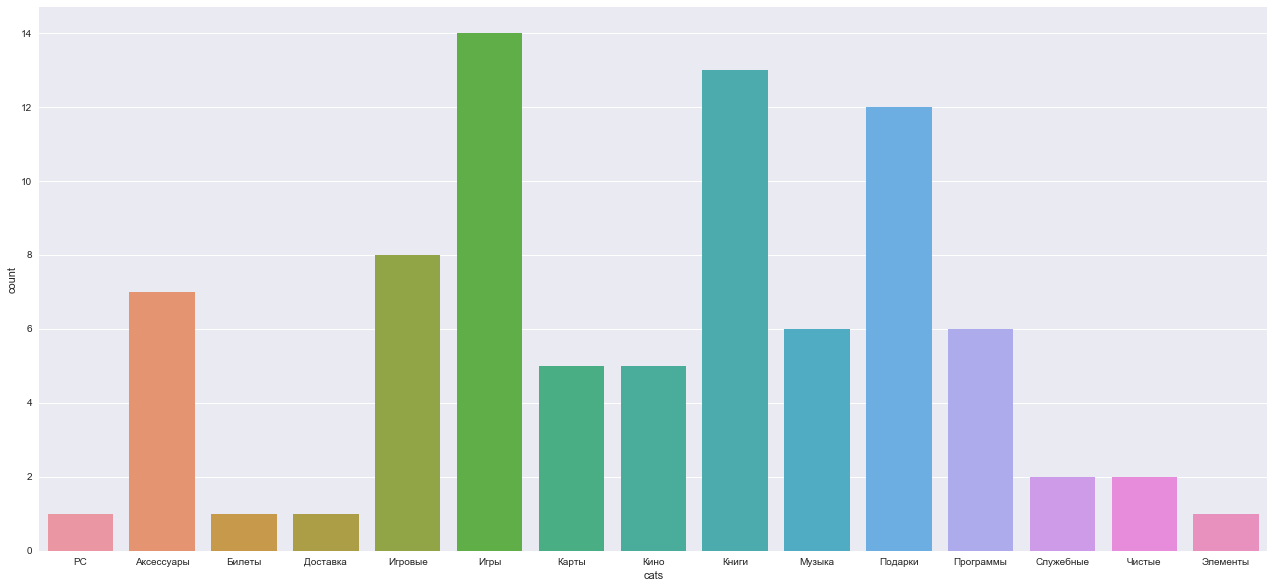

In [46]:
print(item_cats['cats'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(item_cats['cats'])
plt.show()

In [47]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
data =item_to_cat_df['cats'].value_counts()
print(data)
data = [go.Bar(
            x=data.index,
            y=data.values,
            hoverinfo = 'text',
            marker = dict(color = 'rgba(177, 14, 22, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
    )]

layout = dict(
    title = 'categories',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Кино          7464
Музыка        4325
Игры          3955
Подарки       3528
Книги         1273
Программы     1152
Аксессуары     219
Игровые        150
Карты           42
Чистые          15
Элементы        15
Доставка        12
Билеты           9
Служебные        7
PC               4
Name: cats, dtype: int64


In [48]:
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher(n_features=6, input_type='string')
hashed_features = fh.fit_transform(item_cats['cats'])
hashed_features = hashed_features.toarray()
df=pd.concat([item_cats[['item_category_id', 'cats']], pd.DataFrame(hashed_features)], 
          axis=1)

In [49]:
df.head()

,item_category_id,cats,0,1,2,3,4,5
0,0,PC,0.0,0.0,0.0,-1.0,0.0,-1.0
1,1,Аксессуары,1.0,-2.0,-5.0,0.0,0.0,0.0
2,2,Аксессуары,1.0,-2.0,-5.0,0.0,0.0,0.0
3,3,Аксессуары,1.0,-2.0,-5.0,0.0,0.0,0.0
4,4,Аксессуары,1.0,-2.0,-5.0,0.0,0.0,0.0


# shops datasets
 * same as item_cats datasets 
 * this dataset is just obout the name of each shop
 * so all we can do with this data is to come up with a new feature 


In [50]:
shops.shape

(60, 2)

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

#### max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

* max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
* max_df = 25 means "ignore terms that appear in more than 25 documents".

The default max_df is 1.0, which means "ignore terms that appear in more than  100% of the documents". Thus, the default setting does not ignore any terms.

#### min_df is used for removing terms that appear too infrequently. For example:

* min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
* min_df = 5 means "ignore terms that appear in less than 5 documents".

The default min_df is 1, which means "ignore terms that appear in less than 1    document". Thus, the default setting does not ignore any terms.**

In [52]:
bow_converter = CountVectorizer(min_df=2)

In [53]:
x = bow_converter.fit_transform(shops['shop_name'])
x

<60x35 sparse matrix of type '<class 'numpy.int64'>'
	with 135 stored elements in Compressed Sparse Row format>

In [54]:
words = bow_converter.get_feature_names()
len(words)

35

In [55]:
words

['56',
 'ii',
 'буденовский',
 'век',
 'воронеж',
 'горизонт',
 'жуковский',
 'казань',
 'красноярск',
 'магазин',
 'мега',
 'мегацентр',
 'молл',
 'москва',
 'новгород',
 'новосибирск',
 'орджоникидзе',
 'пав',
 'паркхаус',
 'рио',
 'ростовнадону',
 'самара',
 'сити',
 'спб',
 'тк',
 'трк',
 'трц',
 'тц',
 'тюмень',
 'ул',
 'уфа',
 'фран',
 'центральный',
 'чкалова',
 'якутск']

In [56]:
for i, col in enumerate(words):
    shops[col] = pd.SparseSeries(x[:, i].toarray().ravel(), fill_value=0)

In [57]:
shops.head()

,shop_name,shop_id,56,ii,буденовский,век,воронеж,горизонт,жуковский,казань,красноярск,магазин,мега,мегацентр,молл,москва,новгород,новосибирск,орджоникидзе,пав,паркхаус,рио,ростовнадону,самара,сити,спб,тк,трк,трц,тц,тюмень,ул,уфа,фран,центральный,чкалова,якутск
0,"!Якутск Орджоникидзе, 56 фран",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,"!Якутск ТЦ ""Центральный"" фран",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
2,"Адыгея ТЦ ""Мега""",2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,"Волжский ТЦ ""Волга Молл""",4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [58]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

data = [go.Bar(
            x=shops.columns[2:],
            y=[shops[c].sum() for c in shops.columns[2:]],
            hoverinfo = 'text',
            marker = dict(color = 'rgba(177, 14, 22, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
    )]

layout = dict(
    title = 'sub names appearances',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

* is it better to  eliminate those with just two appearances??

In [59]:
col_to_drop=[c for c in shops.columns[2:] if shops[c].sum()<=2]
shop=shops.drop(col_to_drop, axis=1)

In [60]:
l=["shop" for i in range(len(shops))]
for c in shop.columns[2:]:
    for i, x in enumerate(shops[c]):
        if x!=0:
            l[i]=l[i]+" "+c

In [77]:
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher(n_features=6, input_type='string')
hashed_features = fh.fit_transform(l)
hashed_features = hashed_features.toarray()
df=pd.concat([shops[['shop_id']], pd.DataFrame(hashed_features ,columns=["shop_name_"+ str(i) for i in range (6)])], 
          axis=1)

In [78]:
df.head()

,shop_id,shop_name_0,shop_name_1,shop_name_2,shop_name_3,shop_name_4,shop_name_5
0,0,-1.0,-2.0,0.0,-1.0,-2.0,-1.0
1,1,0.0,-5.0,2.0,0.0,-2.0,-1.0
2,2,-1.0,0.0,2.0,0.0,2.0,-1.0
3,3,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
4,4,2.0,0.0,2.0,0.0,1.0,-1.0


* i guess its save not to drop them
#### now lets merge all the datasets with the sales data

In [144]:
sales = pd.merge(sales,item_to_cat_df, how='inner', on="item_id")

In [147]:
sales=pd.merge(sales,shops, how='inner', on="shop_id")

In [148]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 23 columns):
date                object
date_block_num      int64
shop_id             int64
item_id             int64
item_price          float64
item_cnt_day        float64
item_category_id    int64
cats                object
shop_name           object
ii                  int64
воронеж             int64
мега                int64
молл                int64
москва              int64
новосибирск         int64
ростовнадону        int64
тк                  int64
трк                 int64
трц                 int64
тц                  int64
тюмень              int64
центральный         int64
якутск              int64
dtypes: float64(2), int64(18), object(3)
memory usage: 537.6+ MB


### it looks like we have outliers on item_cnt_day and item_price